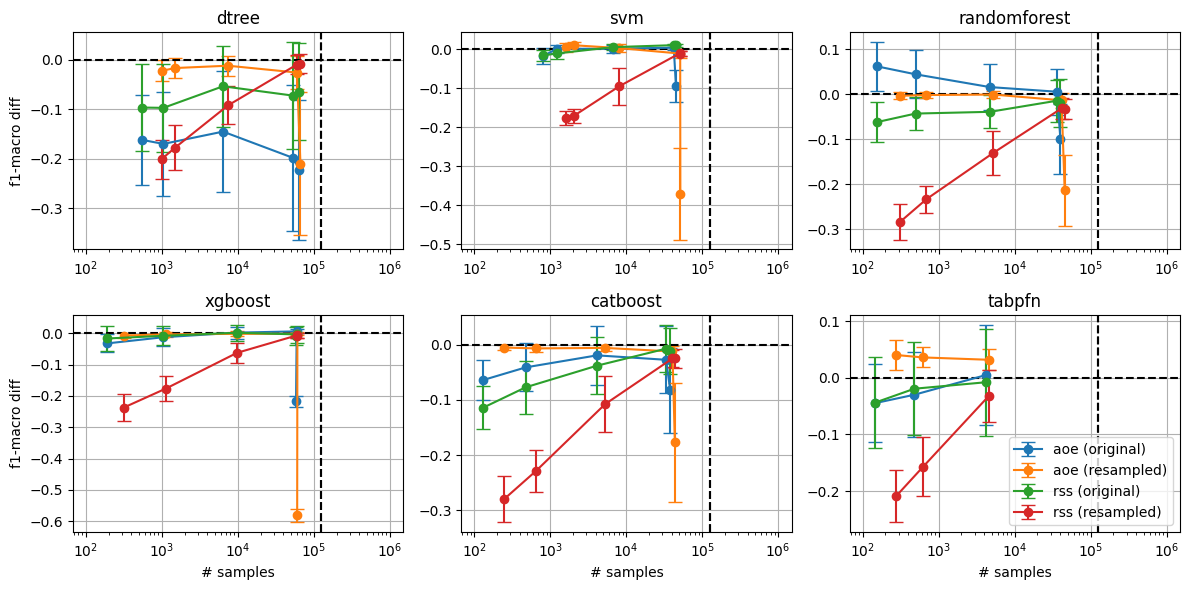

In [1]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

folder = "Exp1_Only_one_epoch"

dsfolders = glob(f"{folder}/n*")
dfs = {}
for dsfolder in dsfolders:
    csvpaths = glob(dsfolder + "/*.csv")
    ds = dsfolder.replace(f"{folder}/","")
    dfs[ds] = {os.path.basename(csvpath).replace(".csv",""): pd.read_csv(csvpath) for csvpath in csvpaths}

def generatefigure(key):
    for col in ["f1-aoe", "f1-rss"]:

        ds = "normal_attacks_original"
        df = dfs[ds][key]
        dy = df[col + " (m)"].values - df["f1-c (m)"].values
        yerr = np.sqrt(df[col + ' (s)'].values**2 + df['f1-c (s)'].values**2)
        label = col.replace("f1-","") + " (original)"
        plt.errorbar(df['Nds-aoe (m)'], dy, yerr=yerr, fmt='o-', capsize=5, label=label) 

        ds = "normal_attacks_resampled"
        df = dfs[ds][key]
        dy = df[col + " (m)"].values - df["f1-c (m)"].values
        yerr = np.sqrt(df[col + ' (s)'].values**2 + df['f1-c (s)'].values**2)
        label = col.replace("f1-","") + " (resampled)"
        plt.errorbar(df['Nds-aoe (m)'], dy, yerr=yerr, fmt='o-', capsize=5, label=label)

        plt.xscale('log')
        plt.title(key)
        plt.grid(True)
        #plt.ylim([-0.3,0.2])
        plt.xlim([1e2-32,1e6+500000])
        plt.tight_layout()

fig = plt.figure(figsize=(12,6))
models = ['dtree', 'svm', 'randomforest', 'xgboost', 'catboost', 'tabpfn']  # 
for i, model in enumerate(models):
    plt.subplot(2,3,i+1)
    generatefigure(model)
    plt.legend() if i == 5 else None
    plt.xlabel('# samples') if i+1 in [4,5,6] else None
    plt.ylabel('f1-macro diff') if i+1 in [1,4] else None
for ax in fig.axes:
    ax.axhline(0, linewidth=1.5, color='black', linestyle='--')
    ax.axvline(125973, linewidth=1.5, color='black', linestyle='--')
    ax.axvline(126239, linewidth=1.5, color='black', linestyle='--')
plt.savefig(f"figures/f1comparative.svg", dpi=300, bbox_inches='tight')
plt.show()

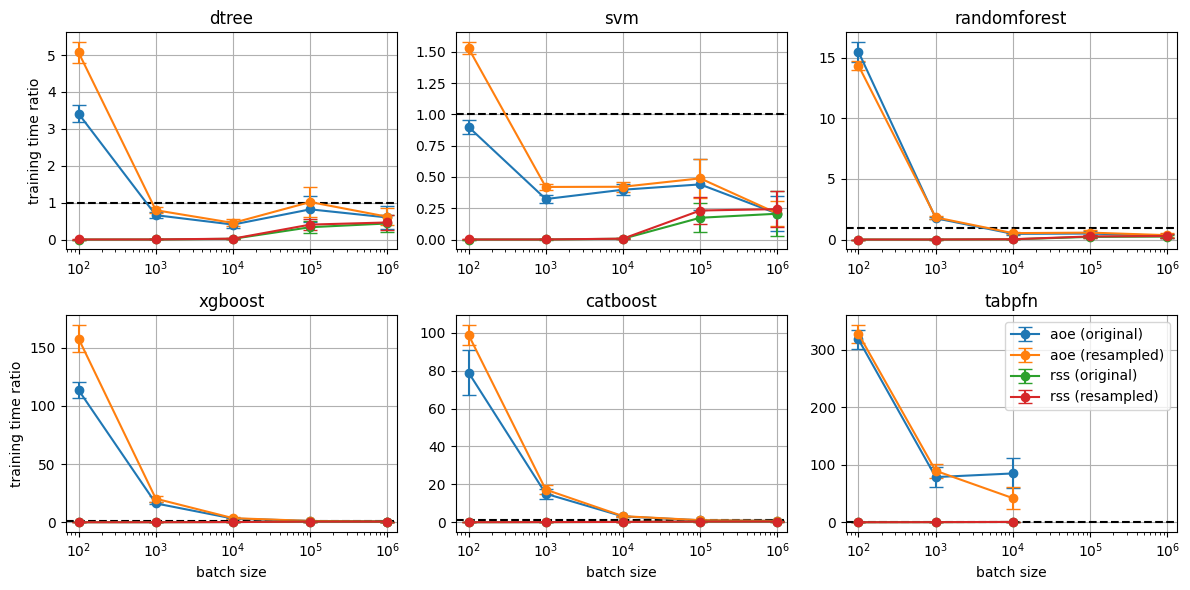

In [2]:
def compute_std_ratio(mu_x, std_x, mu_y, std_y):
    mu_z = mu_x / mu_y
    std_z = np.abs(mu_z)*np.sqrt((std_x / mu_x)**2 + (std_y / mu_y)**2)
    return std_z

def generatefigure(key):
    for col in ["t-aoe", "t-rss"]: #

        ds = "normal_attacks_original"
        df = dfs[ds][key]
        dy = df[col + " (m)"].values/df["t-c (m)"].values
        label = col.replace("t-","") + " (original)"
        yerr = compute_std_ratio(df[col + ' (m)'].values, df[col + ' (s)'].values,  df['t-c (m)'].values, df['t-c (s)'].values)
        plt.errorbar(df['bs'], dy, yerr=yerr, fmt='o-', capsize=5, label=label)  

        ds = "normal_attacks_resampled"
        df = dfs[ds][key]
        dy = df[col + " (m)"].values/df["t-c (m)"].values
        label = col.replace("t-","") + " (resampled)"
        yerr = compute_std_ratio(df[col + ' (m)'].values, df[col + ' (s)'].values,  df['t-c (m)'].values, df['t-c (s)'].values)
        plt.errorbar(df['bs'], dy, yerr=yerr, fmt='o-', capsize=5, label=label)  

        plt.xscale('log')
        plt.title(key)
        plt.grid(True)
        #plt.ylim([-0.3,0.2])
        plt.xlim([1e2-32,1e6+320000])
        plt.tight_layout()

fig = plt.figure(figsize=(12,6))
models = ['dtree', 'svm', 'randomforest', 'xgboost', 'catboost', 'tabpfn']
for i, model in enumerate(models):
    plt.subplot(2,3,i+1)
    generatefigure(model)
    plt.legend() if i == 5 else None
    plt.xlabel('batch size') if i+1 in [4, 5,6] else None
    plt.ylabel('training time ratio') if i+1 in [1,4] else None
for ax in fig.axes:
    ax.axhline(1.0, linewidth=1.5, color='black', linestyle='--')
plt.savefig(f"figures/timecomparative.svg", dpi=300, bbox_inches='tight')
plt.show()

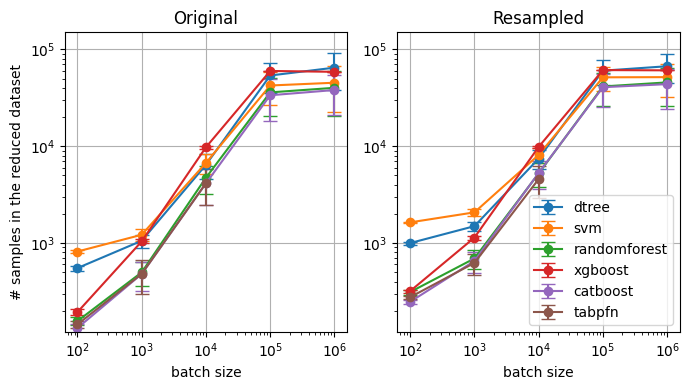

In [3]:
def generatefigureNs(ds):
    models = ['dtree', 'svm', 'randomforest', 'xgboost', 'catboost', 'tabpfn']
    for model in models:
        df = dfs[ds][model]
        plt.errorbar(df['bs'], df['Nds-aoe (m)'], yerr=df['Nds-aoe (s)'], fmt='o-', capsize=5, label=model)  
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.title(ds.replace('normal_attacks_','').capitalize())
    plt.ylim([1e2+20,1e5+0.5e5])
    plt.xlabel("batch size")

plt.figure(figsize=(7,4))
plt.subplot(121)
generatefigureNs("normal_attacks_original")
plt.ylabel("# samples in the reduced dataset")
plt.subplot(122)
generatefigureNs("normal_attacks_resampled")
plt.legend()
plt.savefig(f"figures/samplescomparative.svg", dpi=300, bbox_inches='tight')
plt.show()


0.9997983379870732
0.6691309428680553


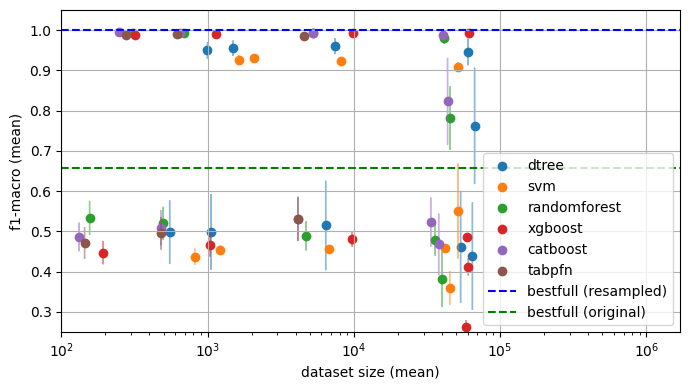

In [4]:
# Grafica: N samples vs f1-macro 
# ¿cual es el modelo con mejor f1-macro y menos smaples? 
from matplotlib.patches import Circle


models = ['dtree', 'svm', 'randomforest', 'xgboost', 'catboost', 'tabpfn']
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for ds in dfs.keys():
    f1_c = []
    for model in models:
        df = dfs[ds][model]
        f1_c.append(df['f1-c (m)'].max().item()) 
    print(max(f1_c))  # catboost y dtree son los mejores

plt.figure(figsize=(7,4))
for model, color in zip(models, c):
    n_samples, f1s, stds = [], [], []
    for ds in dfs.keys():
        df = dfs[ds][model]
        n_samples += df['Nds-aoe (m)'].tolist()
        f1s += df['f1-aoe (m)'].tolist()
        stds += df['f1-aoe (s)'].tolist()
    plt.scatter(n_samples, f1s, color=color, label=model)
    for xi, yi, si in zip(n_samples, f1s, stds):
        circle = Circle((xi, yi), radius=si, color=color, alpha=0.5)
        plt.gca().add_patch(circle)

plt.hlines([0.9994324754120106], 1e2, 1e6+700000, color='blue', linestyle='--', label='bestfull (resampled)')
plt.hlines([0.6573035152253484], 1e2, 1e6+700000, color='green', linestyle='--', label='bestfull (original)')
plt.xscale('log')
plt.legend(loc='lower right')
plt.ylim([0.25,1.05])
plt.xlim([1e2,1e6+700000])
plt.xlabel('dataset size (mean)')
plt.ylabel('f1-macro (mean)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"figures/datasetsizeVSf1.svg", dpi=300, bbox_inches='tight')
plt.show()

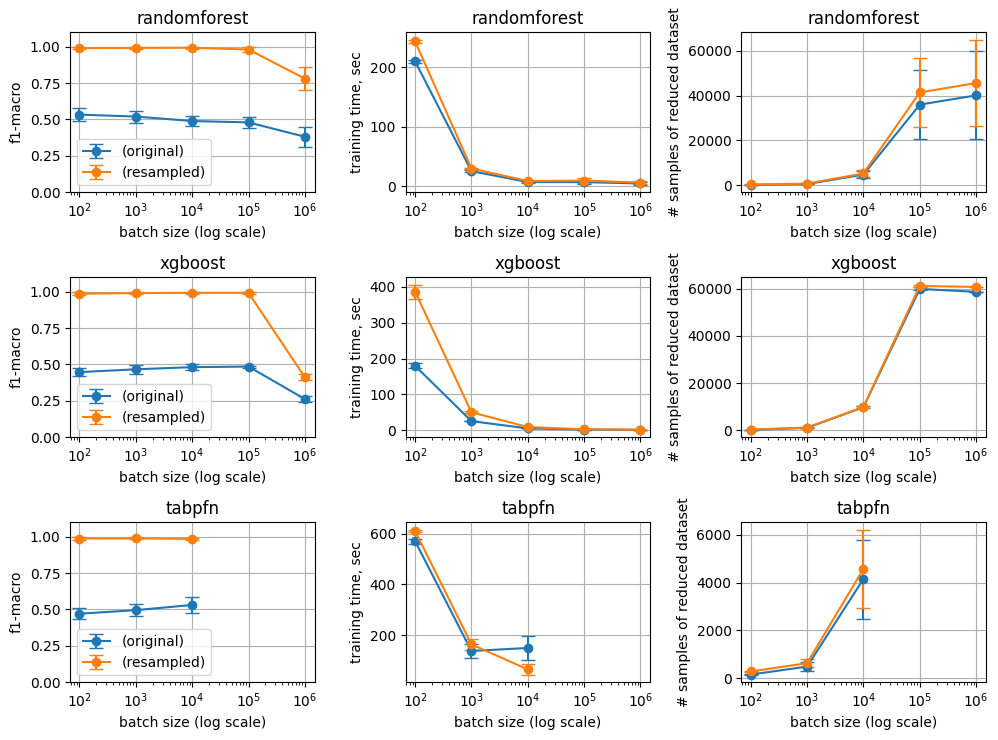

In [5]:
def generatefiguref1(key):
    ds = "normal_attacks_original"
    df = dfs[ds][key]
    y = df["f1-aoe (m)"].values
    yerr = df['f1-aoe (s)'].values
    label = "(original)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    ds = "normal_attacks_resampled"
    df = dfs[ds][key]
    y = df["f1-aoe (m)"].values
    yerr = df['f1-aoe (s)'].values
    label = "(resampled)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    plt.xscale('log')
    plt.title(key)
    plt.grid(True)
    plt.ylim([0,1.1])
    plt.xlim(xlimvalues)
    plt.legend()
    plt.xlabel('batch size (log scale)') 
    plt.ylabel('f1-macro')

def generatefiguretime(key):
    ds = "normal_attacks_original"
    df = dfs[ds][key]
    y = df["t-aoe (m)"].values
    yerr = df['t-aoe (s)'].values
    label = "(original)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    ds = "normal_attacks_resampled"
    df = dfs[ds][key]
    y = df["t-aoe (m)"].values
    yerr = df['t-aoe (s)'].values
    label = "(resampled)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    plt.xscale('log')
    plt.title(key)
    plt.grid(True)
    #plt.ylim([0,1.1])
    plt.xlim(xlimvalues)
    plt.xlabel('batch size (log scale)') 
    plt.ylabel('training time, sec')

def generatefigureNs(key):
    ds = "normal_attacks_original"
    df = dfs[ds][key]
    y = df["Nds-aoe (m)"].values
    yerr = df['Nds-aoe (s)'].values
    label = "(original)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    ds = "normal_attacks_resampled"
    df = dfs[ds][key]
    y = df["Nds-aoe (m)"].values
    yerr = df['Nds-aoe (s)'].values
    label = "(resampled)"
    plt.errorbar(df['bs'], y, yerr=yerr, fmt='o-', capsize=5, label=label)  

    plt.xscale('log')
    #plt.yscale('log')
    plt.title(key)
    plt.grid(True)
    #plt.ylim([0,1.1])
    plt.xlim(xlimvalues)
    plt.xlabel('batch size (log scale)') 
    plt.ylabel('# samples of reduced dataset')

models = ['randomforest', 'xgboost', 'tabpfn']
xlimvalues = [1e2-32,1e6+500000]

fig = plt.figure(figsize=(10,2.5*3))
for i, model in enumerate(models):
    plt.subplot(3,3,3*i+1)
    generatefiguref1(model)
    plt.legend()
    plt.subplot(3,3,3*i+2)
    generatefiguretime(model)
    plt.subplot(3,3,3*i+3)
    generatefigureNs(model)
    plt.tight_layout()
plt.savefig(f"figures/f1_time_samples.svg", dpi=300, bbox_inches='tight')
plt.show()